## 神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

神经元

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_back(z):
    return sigmoid(z)*(1-sigmoid(z))

def softmax(z):
    return np.exp(z)/ np.sum(np.exp(z), axis=1, keepdims=True)

def softmax_back(a, y):
    return a - y

def relu(z):
    return np.maximum(z, 0)

def relu_back(z):
    dz = np.array(z, copy=True)
    dz[z>=0] = 1
    dz[z<0] = 0
    return dz

In [3]:
class Neural_Network():

    def __init__(self, L, activations):
        self.L = L
        self.activations = activations
        self.l = len(L)
        
        self.cache = {}
        self.param = {}
        self.grad = {}
        self.costs = []

    ##初始化参数

    def init_param(self, num_feature):
        
        self.param['W_'+str(1)] = np.random.normal(size=[num_feature, self.L[0]]) * np.sqrt(2/num_feature)
#        self.param['W_'+str(1)] = np.zeros([num_feature, self.L[0]])
        self.param['b_'+str(1)] = np.zeros(self.L[0])
        
        for i in range(1,self.l):
            self.param['W_'+str(i+1)] = np.random.normal(size=[self.L[i-1], self.L[i]]) * np.sqrt(2/self.L[i-1])
#            self.param['W_'+str(i+1)] = np.zeros([self.L[i-1], self.L[i]])
            self.param['b_'+str(i+1)] = np.zeros(self.L[i])

        return self.param 

    ##forward 前向

    def forward(self, x, keep_prob=1.0):      
        
        a_pre = x
        for i in range(0, self.l):
            W = self.param['W_'+str(i+1)]
            b = self.param['b_'+str(i+1)]
            z = np.dot(a_pre, W) + b

            if self.activations[i] == 'relu':
                a = relu(z)  
                
            elif self.activations[i] == 'sigmoid':
                a = sigmoid(z)
                
            elif self.activations[i] == 'softmax':
                a = softmax(z)
            
            
            if i != self.l - 1:
                d = np.random.rand(a.shape[0], a.shape[1])
                d = d < keep_prob
                a = a * d / keep_prob   
                self.cache['d_'+str(i+1)] = d
            
            
            a_pre = a

            self.cache['z_'+str(i+1)] = z
            self.cache['a_'+str(i+1)] = a
            

        return self.cache

    ## cost 损失

    def cost_function(self, y, y_):
#        y_mask = np.ma.masked_values(y_, 0)
#        cost = - np.sum(np.log(y_[y.astype(np.bool)])) / y.shape[0]
        cost = 1 / (2*y.shape[0]) * np.sum((y - y_)**2) #+ self.lambd/(2*self.m) * np.sum(np.square(Wl))
#        cost = -1 / y.shape[0] * np.sum(y*np.log(y_) + (1-y)*np.log(1-y_))
        cost = np.squeeze(cost)
        return cost


    ## backward 后项

    def backward(self, y, keep_prob=1.):
        
        y_ = self.cache['a_'+str(self.l)]
#        da = - 1 / y_ 

        dz = softmax_back(y_, y)
        
        W = self.param['W_'+str(self.l)]
        a_pre = self.cache['a_'+str(self.l-1)]
        
        dW = 1/self.m * np.dot(a_pre.T, dz) + self.lambd / self.m * W
        db = 1/self.m * np.sum(dz, axis=0)
        
        self.grad['dW_'+str(self.l)] = dW 
        self.grad['db_'+str(self.l)] = db
                  

        for i in range(self.l-1, 0, -1):
            W_back = self.param['W_'+str(i+1)]
            da = np.dot(dz, W_back.T)
            
            ##dropou
            da = da * self.cache['d_'+str(i)] / keep_prob
            
            z = self.cache['z_'+str(i)]
            a_pre = self.cache['a_'+str(i-1)]
            W = self.param['W_'+str(i)]

            if self.activations[i-1] == 'relu':
                dz = da * relu_back(z)
            elif self.activations[i-1] == 'sigmoid':
                dz = da * sigmoid_back(z)
            elif self.activations[i-1] == 'softmax':
                dz = da * softmax_back(z)


            dW = 1/self.m * np.dot(a_pre.T, dz) + self.lambd / self.m * W
            db = 1/self.m * np.sum(dz, axis=0)

            self.grad['dW_'+str(i)] = dW 
            self.grad['db_'+str(i)] = db

            
#            da = np.dot(dz, W.T)
            

        return self.grad

    ## update 更新

    def updata_param(self):
        for i in range(1, self.l+1):
            self.param['W_'+str(i)] -= self.alpha * self.grad['dW_'+str(i)]
            self.param['b_'+str(i)] -= self.alpha * self.grad['db_'+str(i)]   

        return self.param

    ## train 训练

    def train(self, x, y, alpha=0.01, lambd=0, keep_prob=1.):
        self.alpha = alpha        
        self.m = x.shape[0]
        self.cache['a_0'] = x
        self.lambd = lambd
        
        self.forward(x, keep_prob)

        cost = self.cost_function(y, self.cache['a_'+str(self.l)])
        
        self.costs.append(cost)

        self.backward(y, keep_prob)

        self.updata_param()
        

        return self.param, self.costs
    
    def cost_test(self, x, y):
        cache = self.forward(x)
        a = cache['a_'+str(self.l)]
        cost = self.cost_function(y, a)
        return cost
        
    ## 预测
    def predict(self, x):
        cache = self.forward(x)
        a = cache['a_'+str(self.l)]
        a_max = np.argmax(a, axis=1)    
        index = np.arange(a.shape[0]) * a.shape[1]
        y_ = np.zeros_like(a)
        y_.flat[a_max + index] = 1

        return y_

In [4]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
data = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()    
scaler.fit(data.train.images)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
L = [10,10,5,10]
activations = [ 'relu', 'relu', 'relu', 'softmax']
nn = Neural_Network(L, activations)
paramaters = nn.init_param(28*28)
cost_tests = []
batch_test = data.test.next_batch(100)

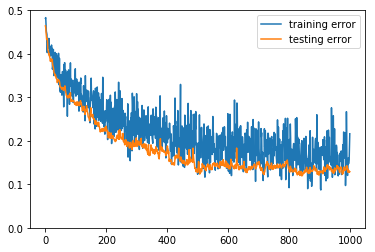

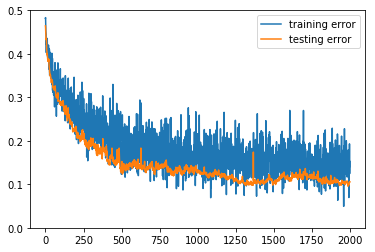

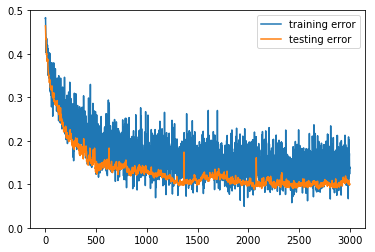

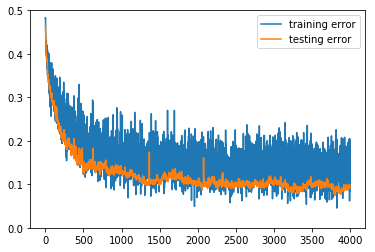

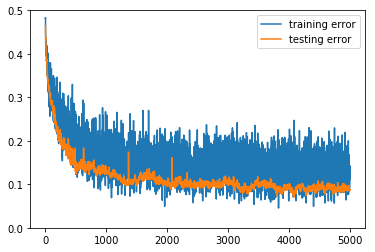

In [7]:
for i in range(1, 5000):
    batch = data.train.next_batch(50)  
    nn.train(scaler.transform(batch[0]), batch[1], alpha=0.1, lambd=0.2, keep_prob=0.95)
    
      
    cost_test = nn.cost_test(scaler.transform(batch_test[0]), batch_test[1])
    cost_tests.append(cost_test)

    if (i+1) % 1000 == 0:
        plt.plot(nn.costs, label ='training error')
        plt.plot(cost_tests, label ='testing error')
        plt.ylim(0,0.5)
        plt.legend()
        plt.show()

In [8]:
from sklearn.metrics import accuracy_score
print('Training accuracy:',accuracy_score(
    data.train.labels, nn.predict(
        scaler.transform(data.train.images))))
print('Testing accuracy:',accuracy_score(
        data.test.labels, nn.predict(
            scaler.transform(data.test.images))))

Training accuracy: 0.910272727273
Testing accuracy: 0.9074


9


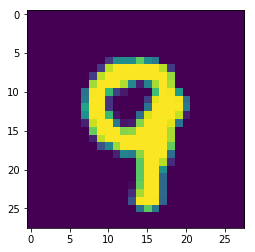

In [10]:
x_test = data.test.next_batch(1)[0]
y_ = nn.predict(scaler.transform(x_test))
print(np.argmax(y_))
plt.imshow(x_test.reshape([28,28]))